In [111]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import *
import sqlite3
import time
from collections import Counter
# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
import scipy
sns.set()
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

In [6]:
df=pd.read_csv("BPI_Challenge_2012.xes.gz_UNPACKED.csv", index_col=[0])
start1 = time.time()

In [7]:
df.head()

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000


In [8]:
df.drop(columns=['org:resource'], inplace=True)
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['time:timestamp'], errors='coerce', utc=True)
df['next_event'] = df['concept:name'].shift(-1)
df['next_case'] = df['case:concept:name'].shift(-1).fillna(0)
df['next_datetime'] = df['datetime'].shift(-1)
df['timedelta'] = (df['next_datetime'] - df['datetime']).astype('timedelta64[s]')


In [9]:
df.iloc[:10]
trainlen = int(len(df)*0.7)
dftrain = df[:trainlen]
dftest = df[trainlen:]


In [10]:
# Get the most common next event type for the given ev_type
# This function replaces block 10 til 15 (10: "def nth_most_common(w, n):", 15: "next_common_train")
def get_most_common_next_type(n, ev_type):
    # Find all rows of the given event type
    target_rows = n[n['concept:name'] == ev_type]
    successors = []
    
    # Loop over all rows of the given event type
    for idx, row in target_rows.iterrows():
        
        # Only check the next row if it exists in the DF
        if idx + 1 < len(n):
            current_case = row['case:concept:name']
            next_case = n.loc[n.index[idx + 1], 'case:concept:name']

            # If the next event in the DF is in the same case, add the event type to the successors list
            if current_case == next_case:
                successors.append(n.loc[n.index[idx + 1], 'concept:name'])
    
    # Return the most common event type in the successors list
    return max(set(successors), key=successors.count) if len(successors) > 0 else None


In [11]:
event_types = df['concept:name'].unique()

most_common_next_types = {}
for ev_type in event_types:
    most_common_next_types[ev_type] = get_most_common_next_type(dftrain, ev_type=ev_type)
    

In [12]:

df.iloc[24:30]

,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,datetime,next_event,next_case,next_datetime,timedelta
24,COMPLETE,A_ACTIVATED,2011-10-13 10:37:29.226000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2011-10-13 08:37:29.226000+00:00,W_Valideren aanvraag,173688.0,2011-10-13 08:37:37.026000+00:00,7.0
25,COMPLETE,W_Valideren aanvraag,2011-10-13 10:37:37.026000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2011-10-13 08:37:37.026000+00:00,A_SUBMITTED,173691.0,2011-10-01 06:08:58.256000+00:00,-1045719.0
26,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256000+02:00,2011-10-01 08:08:58.256000+02:00,173691,5000,2011-10-01 06:08:58.256000+00:00,A_PARTLYSUBMITTED,173691.0,2011-10-01 06:09:02.195000+00:00,3.0
27,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 08:09:02.195000+02:00,2011-10-01 08:08:58.256000+02:00,173691,5000,2011-10-01 06:09:02.195000+00:00,A_PREACCEPTED,173691.0,2011-10-01 06:09:56.648000+00:00,54.0
28,COMPLETE,A_PREACCEPTED,2011-10-01 08:09:56.648000+02:00,2011-10-01 08:08:58.256000+02:00,173691,5000,2011-10-01 06:09:56.648000+00:00,W_Completeren aanvraag,173691.0,2011-10-01 06:09:59.578000+00:00,2.0
29,SCHEDULE,W_Completeren aanvraag,2011-10-01 08:09:59.578000+02:00,2011-10-01 08:08:58.256000+02:00,173691,5000,2011-10-01 06:09:59.578000+00:00,W_Completeren aanvraag,173691.0,2011-10-01 09:37:32.393000+00:00,12452.0


In [13]:
dfs = pd.DataFrame(dftrain[['next_case', 'case:concept:name', 'concept:name', 'timedelta' ]])

In [14]:
c=0
a=0
time_till_next={}
for j in event_types:
    a=0
    for row, value in dfs.iterrows():
        if value['next_case'] == value['case:concept:name']:
            if value['concept:name'] == j:
                a += (value['timedelta'])
                c+=1
    print(j, a, c,)
    time_till_next[j] = a/c
time_till_next

# c=0
# a=0
# time_till_next={}
# va = []
# for row, value in dfs.iterrows():
#     if value['next_case'] == value['case:concept:name']:
#         if 'count'+value['concept:name'] in va:
#             'count'+value['concept:name'] += 1
#             time_till_next[value['concept:name']] = [count, sums += value['timedelta']]
#         c+=1
# print(j, a, c,)
# time_till_next[j] = a/c
# time_till_next

A_SUBMITTED 2181.0 9043
A_PARTLYSUBMITTED 314364.0 18086
A_PREACCEPTED 868.0 23117
W_Completeren aanvraag 2255456277.0 59076
A_ACCEPTED 789028.0 62577
O_SELECTED 6661.0 67396
A_FINALIZED 6116.0 70835
O_CREATED 19.0 75654
O_SENT 150.0 80473
W_Nabellen offertes 4094865660.0 117372
O_SENT_BACK 269.0 119771
W_Valideren aanvraag 99092786.0 132381
A_REGISTERED 5595.0 133991
A_APPROVED 92806.0 135602
O_ACCEPTED 1278.0 137210
A_ACTIVATED 5446.0 138821
O_CANCELLED 164665.0 141224
W_Wijzigen contractgegevens 453835.0 141231
A_DECLINED 9142.0 144243
A_CANCELLED 163646.0 145796
W_Afhandelen leads 91437971.0 155836
O_DECLINED 1013.0 156407
W_Nabellen incomplete dossiers 457490666.0 174081
W_Beoordelen fraude 11067737.0 174498


{'A_SUBMITTED': 0.24118102399646135,
 'A_PARTLYSUBMITTED': 17.381621143425853,
 'A_PREACCEPTED': 0.03754812475667258,
 'W_Completeren aanvraag': 38178.892900670326,
 'A_ACCEPTED': 12.608913818176006,
 'O_SELECTED': 0.09883375868004037,
 'A_FINALIZED': 0.08634149784710948,
 'O_CREATED': 0.0002511433632061755,
 'O_SENT': 0.0018639792228449293,
 'W_Nabellen offertes': 34887.92608117779,
 'O_SENT_BACK': 0.002245952693055915,
 'W_Valideren aanvraag': 748.5423587977126,
 'A_REGISTERED': 0.04175653588673866,
 'A_APPROVED': 0.684399935104202,
 'O_ACCEPTED': 0.009314189927847825,
 'A_ACTIVATED': 0.0392303758076948,
 'O_CANCELLED': 1.1659845352064804,
 'W_Wijzigen contractgegevens': 3.213423398545645,
 'A_DECLINED': 0.06337915878066873,
 'A_CANCELLED': 1.1224313424236605,
 'W_Afhandelen leads': 586.7576875689828,
 'O_DECLINED': 0.006476692219657688,
 'W_Nabellen incomplete dossiers': 2628.0333063344074,
 'W_Beoordelen fraude': 63.42615388141984}

In [15]:
dftest['timedelta_baseline'] = dftest['concept:name'].map(time_till_next)
dftest['next_event_baseline'] = dftest['concept:name'].map(most_common_next_types)

C:\Users\20175892\AppData\Local\Temp\ipykernel_19524\2423298301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['timedelta_baseline'] = dftest['concept:name'].map(time_till_next)
C:\Users\20175892\AppData\Local\Temp\ipykernel_19524\2423298301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['next_event_baseline'] = dftest['concept:name'].map(most_common_next_types)


In [16]:
dftest.iloc[-10:]

,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,datetime,next_event,next_case,next_datetime,timedelta,timedelta_baseline,next_event_baseline
262190,SCHEDULE,W_Nabellen offertes,2012-03-01 20:22:40.149000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,2012-03-01 19:22:40.149000+00:00,W_Completeren aanvraag,214373.0,2012-03-01 19:22:41.157000+00:00,1.0,34887.926081,W_Nabellen offertes
262191,COMPLETE,W_Completeren aanvraag,2012-03-01 20:22:41.157000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,2012-03-01 19:22:41.157000+00:00,W_Nabellen offertes,214373.0,2012-03-10 11:46:22.700000+00:00,750221.0,38178.892901,W_Completeren aanvraag
262192,START,W_Nabellen offertes,2012-03-10 12:46:22.700000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,2012-03-10 11:46:22.700000+00:00,W_Nabellen offertes,214373.0,2012-03-10 11:50:54.881000+00:00,272.0,34887.926081,W_Nabellen offertes
262193,COMPLETE,W_Nabellen offertes,2012-03-10 12:50:54.881000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,2012-03-10 11:50:54.881000+00:00,A_SUBMITTED,214376.0,2012-02-29 22:51:16.799000+00:00,-824379.0,34887.926081,W_Nabellen offertes
262194,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-02-29 22:51:16.799000+00:00,A_PARTLYSUBMITTED,214376.0,2012-02-29 22:51:17.423000+00:00,0.0,0.241181,A_PARTLYSUBMITTED
262195,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-02-29 22:51:17.423000+00:00,W_Afhandelen leads,214376.0,2012-02-29 22:52:01.287000+00:00,43.0,17.381621,W_Afhandelen leads
262196,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-02-29 22:52:01.287000+00:00,W_Afhandelen leads,214376.0,2012-03-01 08:26:46.736000+00:00,34485.0,586.757688,W_Afhandelen leads
262197,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-03-01 08:26:46.736000+00:00,A_DECLINED,214376.0,2012-03-01 08:27:37.118000+00:00,50.0,586.757688,W_Afhandelen leads
262198,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-03-01 08:27:37.118000+00:00,W_Afhandelen leads,214376.0,2012-03-01 08:27:41.325000+00:00,4.0,0.063379,W_Afhandelen leads
262199,COMPLETE,W_Afhandelen leads,2012-03-01 09:27:41.325000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-03-01 08:27:41.325000+00:00,NaN,0.0,NaT,NaN,586.757688,W_Afhandelen leads


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pm4py
import numpy as np
import datetime
import operator
import pickle
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy.stats as stats
np.random.seed(2)
%matplotlib inline
print('test')

test


In [18]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)



In [19]:
#dfn.dropna(inplace=True)
#dft = dfn.drop(columns=['next_datetime', 'timedelta', 'timedelta_baseline', 'next_event_baseline', 'next_event_rfc_pred'])
data_rft = pd.read_csv('https://raw.githubusercontent.com/NickSot/process_mining/main/merged_files/bpi_2012_rft.csv')
data_rft.drop('Unnamed: 0.1', axis=1, inplace=True)
data_rft['next_case'] = data_rft['next_case'].fillna(0).astype(int)
data_rft['lifecycle + event'] = data_rft['lifecycle:transition'] + ' ' + data_rft['event']

In [20]:
data_rft.rename(columns={'A_SUBMITTED': 'A_SUBMITTED_',
                      'A_PARTLYSUBMITTED': 'A_PARTLYSUBMITTED_',
                      'A_PREACCEPTED': 'A_PREACCEPTED_',
                      'W_Completeren aanvraag': 'W_Completeren aanvraag_',
                      'A_ACCEPTED' : 'A_ACCEPTED_', 
                      'O_SELECTED': 'O_SELECTED_', 
                      'A_FINALIZED': 'A_FINALIZED_',
                      'O_CREATED': 'O_CREATED_', 
                      'O_SENT': 'O_SENT_', 
                      'W_Nabellen offertes': 'W_Nabellen offertes_', 
                      'O_SENT_BACK': 'O_SENT_BACK_',
                      'W_Valideren aanvraag': 'W_Valideren aanvraag_', 
                      'A_REGISTERED': 'A_REGISTERED_', 
                      'A_APPROVED': 'A_APPROVED_', 
                      'O_ACCEPTED': 'O_ACCEPTED_',
                      'A_ACTIVATED': 'A_ACTIVATED_', 
                      'O_CANCELLED': 'O_CANCELLED_', 
                      'A_DECLINED': 'A_DECLINED_', 
                      'A_CANCELLED': 'A_CANCELLED_',
                      'W_Afhandelen leads': 'W_Afhandelen leads_',
                      'W_Wijzigen contractgegevens': 'W_Wijzigen contractgegevens_',
                      'W_Beoordelen fraude': 'W_Beoordelen fraude_',
                      'O_DECLINED': 'O_DECLINED_', 
                      'W_Nabellen incomplete dossiers': 'W_Nabellen incomplete dossiers_',
                      'W_Beoordelen fraude': 'W_Beoordelen fraude'}, 
             inplace=True)

In [21]:
train = data_rft[:(int((len(data_rft)*0.7)))]
test = data_rft[(int((len(data_rft)*0.7))):]
all = data_rft
train, test, all = train.dropna(), test.dropna(), all.dropna()
train.columns

Index(['Unnamed: 0', 'org:resource', 'lifecycle:transition', 'event',
       'time:timestamp', 'case:REG_DATE', 'case', 'case:AMOUNT_REQ',
       'next_case', 'next_event', 'A_SUBMITTED_', 'A_PARTLYSUBMITTED_',
       'A_PREACCEPTED_', 'W_Completeren aanvraag_', 'A_ACCEPTED_',
       'O_SELECTED_', 'A_FINALIZED_', 'O_CREATED_', 'O_SENT_',
       'W_Nabellen offertes_', 'O_SENT_BACK_', 'W_Valideren aanvraag_',
       'A_REGISTERED_', 'A_APPROVED_', 'O_ACCEPTED_', 'A_ACTIVATED_',
       'O_CANCELLED_', 'W_Wijzigen contractgegevens_', 'A_DECLINED_',
       'A_CANCELLED_', 'W_Afhandelen leads_', 'O_DECLINED_',
       'W_Nabellen incomplete dossiers_', 'W_Beoordelen fraude',
       'lifecycle + event'],
      dtype='object')

In [22]:
# making dummy variables from the event, in this way the model can use all the different event types.
event_train = pd.get_dummies(train['event'])
event_test = pd.get_dummies(test['event'])

lifecycle_train_ = pd.get_dummies(train['lifecycle:transition'])
lifecycle_test_ = pd.get_dummies(test['lifecycle:transition'])

lifecycle_train = pd.get_dummies(train['lifecycle + event'])
lifecycle_test = pd.get_dummies(test['lifecycle + event'])

lifecycle_train_.head()

,COMPLETE,SCHEDULE,START
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
5,1,0,0


In [23]:
df_train = pd.concat([train, event_train], axis=1)
df_test = pd.concat([test, event_test], axis=1)

df_train_1 = pd.concat([df_train, lifecycle_train_], axis=1)
df_test_1 = pd.concat([df_test, lifecycle_test_], axis=1)

df_train_2 = pd.concat([df_train_1, lifecycle_train], axis=1)
df_test_2 = pd.concat([df_test_1, lifecycle_test], axis=1)
print(len(df_test_1.columns))
print(len(df_test_2.columns))
df_test.tail()

62
98


,Unnamed: 0,org:resource,lifecycle:transition,event,time:timestamp,case:REG_DATE,case,case:AMOUNT_REQ,next_case,next_event,A_SUBMITTED_,A_PARTLYSUBMITTED_,A_PREACCEPTED_,W_Completeren aanvraag_,A_ACCEPTED_,O_SELECTED_,A_FINALIZED_,O_CREATED_,O_SENT_,W_Nabellen offertes_,O_SENT_BACK_,W_Valideren aanvraag_,A_REGISTERED_,A_APPROVED_,O_ACCEPTED_,A_ACTIVATED_,O_CANCELLED_,W_Wijzigen contractgegevens_,A_DECLINED_,A_CANCELLED_,W_Afhandelen leads_,O_DECLINED_,W_Nabellen incomplete dossiers_,W_Beoordelen fraude,lifecycle + event,A_ACCEPTED,A_ACTIVATED,A_APPROVED,A_CANCELLED,A_DECLINED,A_FINALIZED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_REGISTERED,A_SUBMITTED,O_ACCEPTED,O_CANCELLED,O_CREATED,O_DECLINED,O_SELECTED,O_SENT,O_SENT_BACK,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag,W_Wijzigen contractgegevens
262195,262195,112.0,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,214376,W_Afhandelen leads,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,COMPLETE A_PARTLYSUBMITTED,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262196,262196,112.0,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,214376,W_Afhandelen leads,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SCHEDULE W_Afhandelen leads,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
262197,262197,11169.0,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,214376,A_DECLINED,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,START W_Afhandelen leads,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
262198,262198,11169.0,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,214376,W_Afhandelen leads,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,COMPLETE A_DECLINED,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262199,262199,11169.0,COMPLETE,W_Afhandelen leads,2012-03-01 09:27:41.325000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,0,Finished,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,COMPLETE W_Afhandelen leads,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [24]:
# dropping the rows, the model don't need.
from sklearn.model_selection import train_test_split
X_train_ = df_train_2.drop(columns=['Unnamed: 0', 'lifecycle:transition', 'lifecycle + event', 'event', 'time:timestamp', 'case:REG_DATE', 'next_event', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens_', 'COMPLETE O_DECLINED', 'START', 'next_case'])
y_train = df_train_2['next_event']

X_test = df_test_2.drop(columns=['Unnamed: 0', 'lifecycle:transition', 'lifecycle + event', 'event', 'time:timestamp', 'case:REG_DATE', 'next_event', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens_', 'COMPLETE O_DECLINED', 'START',  'next_case'])
y_test = df_test_2['next_event']
len(X_test.columns)

86

In [25]:
# scaling all features 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train_)
X_test = sc.fit_transform(X_test)

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [27]:
test['next_event_rfc_pred'] = rfc_pred

In [28]:
dff = pd.concat([dftest, test[['next_event_rfc_pred']]], axis=1)
dff.head()

,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,datetime,next_event,next_case,next_datetime,timedelta,timedelta_baseline,next_event_baseline,next_event_rfc_pred
183540,SCHEDULE,W_Nabellen incomplete dossiers,2012-02-01 12:32:38.341000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:38.341000+00:00,W_Valideren aanvraag,201854.0,2012-02-01 11:32:39.792000+00:00,1.0,2628.033306,W_Nabellen incomplete dossiers,W_Valideren aanvraag
183541,COMPLETE,W_Valideren aanvraag,2012-02-01 12:32:39.792000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:39.792000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:34:31.007000+00:00,14511.0,748.542359,W_Valideren aanvraag,W_Valideren aanvraag
183542,START,W_Nabellen incomplete dossiers,2012-02-01 16:34:31.007000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:34:31.007000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:37:58.571000+00:00,207.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers
183543,COMPLETE,W_Nabellen incomplete dossiers,2012-02-01 16:37:58.571000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:37:58.571000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:39:05.827000+00:00,67.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers
183544,START,W_Nabellen incomplete dossiers,2012-02-01 16:39:05.827000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:39:05.827000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:42:17.411000+00:00,191.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers


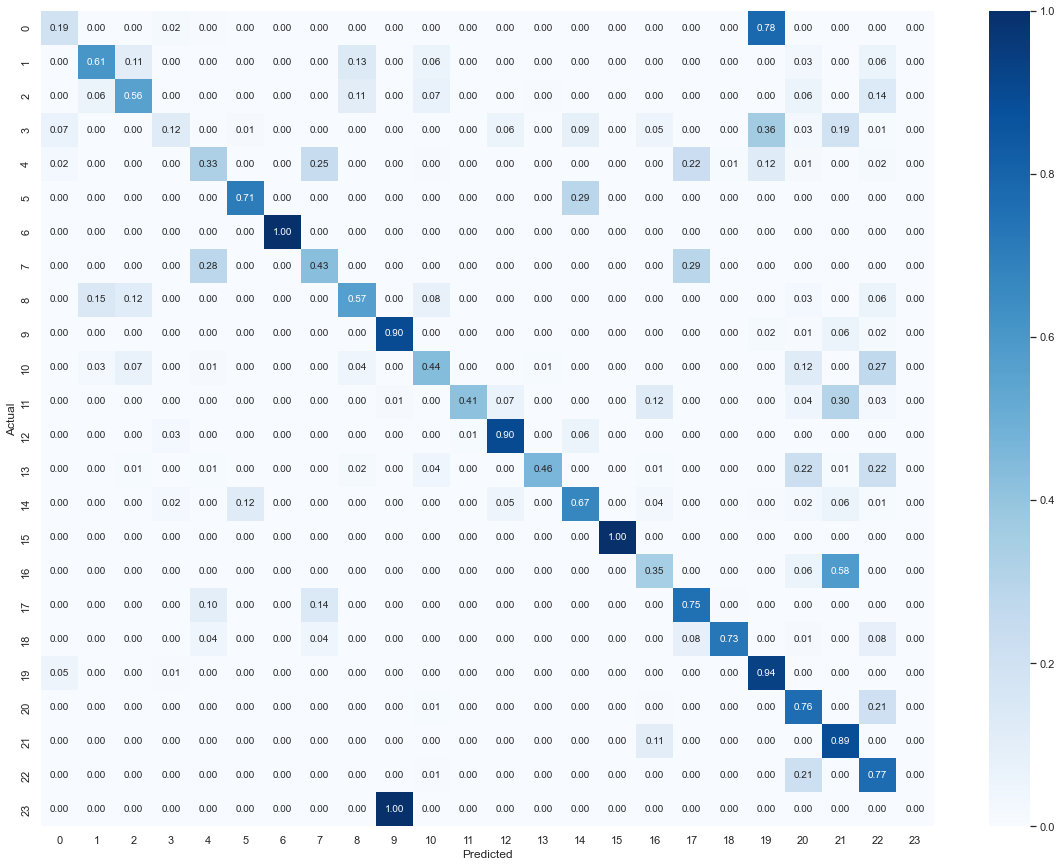

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

labels = list(np.unique(y_test))
cm =confusion_matrix(y_test, rfc_pred, labels=labels)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

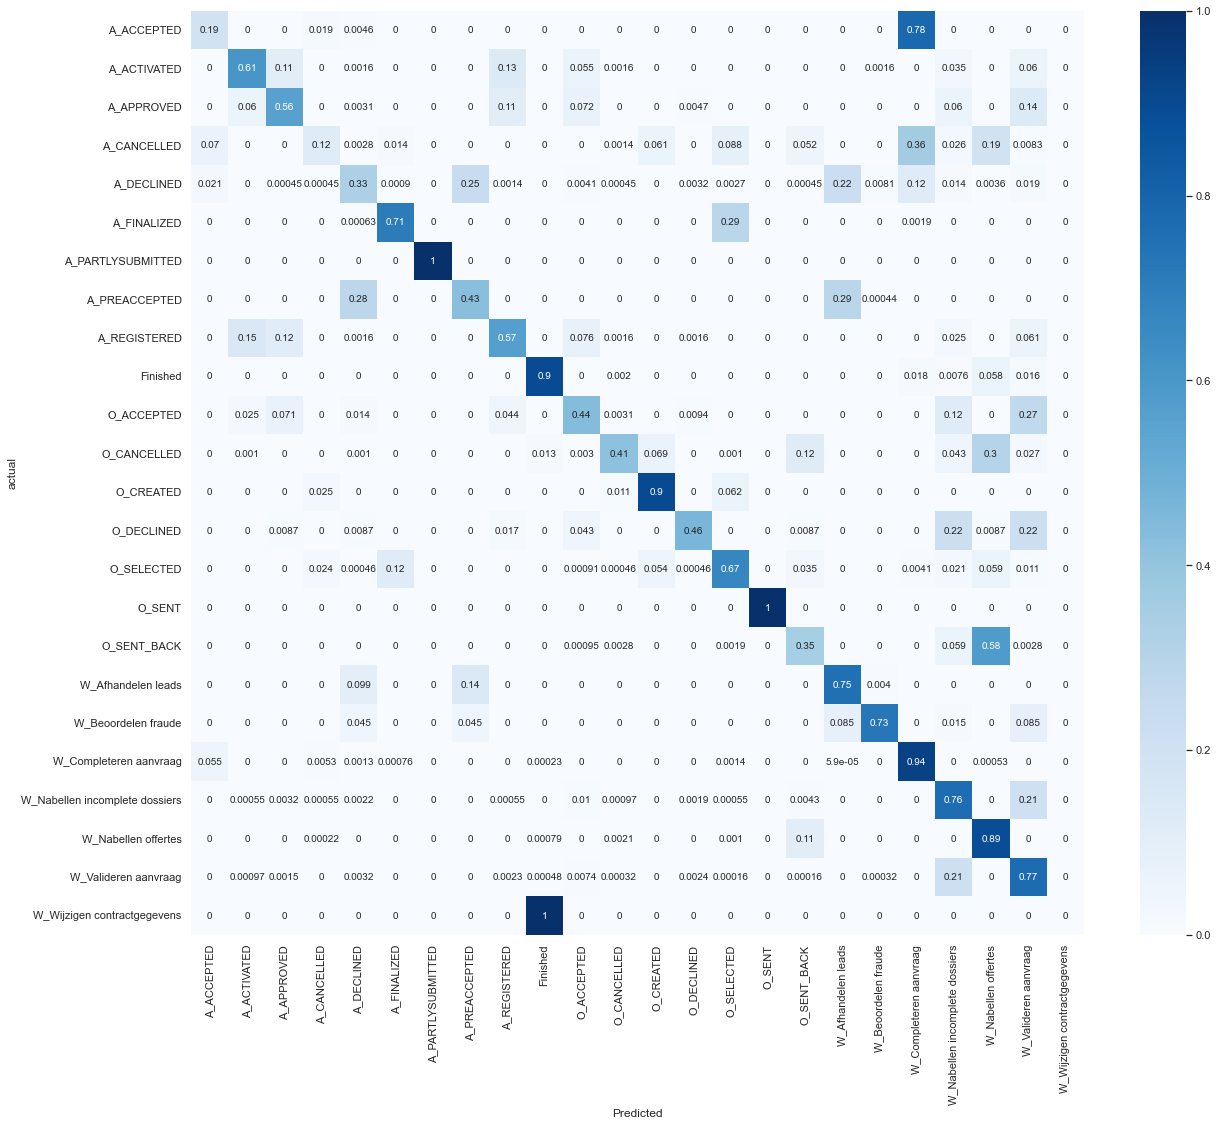

In [30]:
labels = list(np.unique(y_test))
a =  confusion_matrix(y_test, rfc_pred, labels=labels)

cmd = pd.DataFrame(a, index=labels, columns=labels)

cmdn = cmd.div(cmd.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(20,17)) 
sns.heatmap(cmdn, annot=True, cmap='Blues', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('actual')
fig.savefig('norm_confusion_matrix.png', dpi=300)

In [31]:
classification_report(y_test, rfc_pred, output_dict = True)

C:\Users\20175892\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20175892\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20175892\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'A_ACCEPTED': {'precision': 0.22322775263951736,
  'recall': 0.1935905820797907,
  'f1-score': 0.2073555166374781,
  'support': 1529},
 'A_ACTIVATED': {'precision': 0.7077205882352942,
  'recall': 0.6062992125984252,
  'f1-score': 0.6530958439355387,
  'support': 635},
 'A_APPROVED': {'precision': 0.6149825783972126,
  'recall': 0.5559055118110237,
  'f1-score': 0.5839536807278745,
  'support': 635},
 'A_CANCELLED': {'precision': 0.2716049382716049,
  'recall': 0.12121212121212122,
  'f1-score': 0.1676190476190476,
  'support': 726},
 'A_DECLINED': {'precision': 0.37564499484004127,
  'recall': 0.32941176470588235,
  'f1-score': 0.3510125361620058,
  'support': 2210},
 'A_FINALIZED': {'precision': 0.7937411095305832,
  'recall': 0.7081218274111675,
  'f1-score': 0.7484909456740442,
  'support': 1576},
 'A_PARTLYSUBMITTED': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 4044},
 'A_PREACCEPTED': {'precision': 0.44081632653061226,
  'recall': 0.42838254737769943,
  '

In [32]:
# Constructing the feature importance for the model with name "rfr"
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

Text(0, 0.5, 'Mean decrease in impurity')

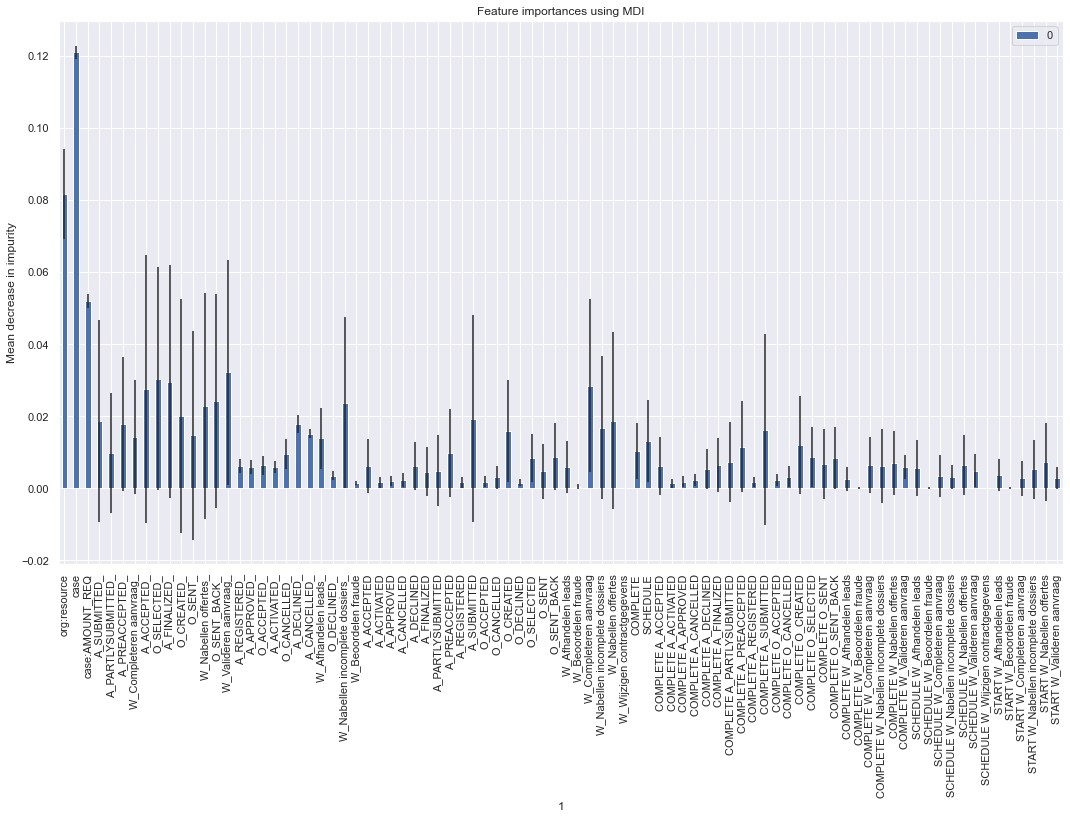

In [33]:
# Plotting a bar chart
X_train_col = X_train_.columns
forest_importances = pd.Series(importances)
df_importances = pd.concat([forest_importances, pd.Series(X_train_col)], axis=1)

fig, ax = plt.subplots()
df_importances.plot.bar(yerr=std, ax=ax, x=1, y=0, figsize=(18, 10))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# **Neural Network for prediction of time of event occurrence**

## **Preprocessing**

In [34]:
np.random.seed(1)
df = pd.read_csv('BPI_Challenge_2012.xes.gz_UNPACKED.csv', index_col=[0])
start = time.time()
df.drop(columns=['org:resource'], inplace=True)
df['next_event'] = df['concept:name'].shift(-1)
df['previous_event'] = df['concept:name'].shift(1)
df['pp_event'] = df['concept:name'].shift(2)
df['ppp_event'] = df['concept:name'].shift(3)
df['p_lifecycle:transition'] = df['lifecycle:transition'].shift(1)
df['next_case'] = df['case:concept:name'].shift(-1).fillna(0)
df['next_case1'] = df['next_case'].shift(-1).fillna(0)
df['datetime'] = pd.to_datetime(df['time:timestamp'], errors='coerce', utc=True)
df['weekday'] = df['datetime'].dt.weekday
df['previous_weekday'] = df['weekday'].shift(1)
df['hour'] =  df['datetime'].dt.hour
df['minute'] =  df['datetime'].dt.minute
df['month'] =  df['datetime'].dt.month
df['next_datetime'] = df['datetime'].shift(-1)
df['timedelta'] = (df['next_datetime'] - df['datetime']).astype('timedelta64[s]')
df = df[(df['case:concept:name'].astype(int)) == (df['next_case'].astype(int))]
df['previous_timedelta'] = df['timedelta'].shift(1)
df['pp_timedelta'] = df['timedelta'].shift(2)
df['ppp_timedelta'] = df['timedelta'].shift(3)
print(len(df))
df.dropna(inplace=True)
df.iloc[:10]
dfxx = df[['hour', 'minute', 'previous_timedelta', 'pp_timedelta', 'ppp_timedelta']]
dfx = df[['concept:name', 'previous_event', 'lifecycle:transition', 'pp_event', 'p_lifecycle:transition', 'weekday']]
dfy = (df[['timedelta']])
valx = dfx
valy = dfy
dummies = pd.get_dummies(dfx.astype('str'))
dfx = dfxx.join(dummies)
trainlen = int(len(df)*0.7)
x_train, y_train = dfx[:trainlen], dfy[:trainlen]
x_test, y_test = dfx[trainlen:], dfy[trainlen:]
df2 = x_train.join(y_train)
dftest = x_test.join(y_test)
valy = y_test
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(len(x_test))
df.iloc[-10:]

249113
74733


,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,next_event,previous_event,pp_event,ppp_event,p_lifecycle:transition,next_case,next_case1,datetime,weekday,previous_weekday,hour,minute,month,next_datetime,timedelta,previous_timedelta,pp_timedelta,ppp_timedelta
262188,COMPLETE,O_CREATED,2012-03-01 20:22:40.016000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,O_SENT,A_FINALIZED,O_SELECTED,A_ACCEPTED,COMPLETE,214373.0,214373.0,2012-03-01 19:22:40.016000+00:00,3,3.0,19,22,3,2012-03-01 19:22:40.043000+00:00,0.0,1.0,0.0,316.0
262189,COMPLETE,O_SENT,2012-03-01 20:22:40.043000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,W_Nabellen offertes,O_CREATED,A_FINALIZED,O_SELECTED,COMPLETE,214373.0,214373.0,2012-03-01 19:22:40.043000+00:00,3,3.0,19,22,3,2012-03-01 19:22:40.149000+00:00,0.0,0.0,1.0,0.0
262190,SCHEDULE,W_Nabellen offertes,2012-03-01 20:22:40.149000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,W_Completeren aanvraag,O_SENT,O_CREATED,A_FINALIZED,COMPLETE,214373.0,214373.0,2012-03-01 19:22:40.149000+00:00,3,3.0,19,22,3,2012-03-01 19:22:41.157000+00:00,1.0,0.0,0.0,1.0
262191,COMPLETE,W_Completeren aanvraag,2012-03-01 20:22:41.157000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,W_Nabellen offertes,W_Nabellen offertes,O_SENT,O_CREATED,SCHEDULE,214373.0,214373.0,2012-03-01 19:22:41.157000+00:00,3,3.0,19,22,3,2012-03-10 11:46:22.700000+00:00,750221.0,1.0,0.0,0.0
262192,START,W_Nabellen offertes,2012-03-10 12:46:22.700000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,W_Nabellen offertes,W_Completeren aanvraag,W_Nabellen offertes,O_SENT,COMPLETE,214373.0,214376.0,2012-03-10 11:46:22.700000+00:00,5,3.0,11,46,3,2012-03-10 11:50:54.881000+00:00,272.0,750221.0,1.0,0.0
262194,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,A_PARTLYSUBMITTED,W_Nabellen offertes,W_Nabellen offertes,W_Completeren aanvraag,COMPLETE,214376.0,214376.0,2012-02-29 22:51:16.799000+00:00,2,5.0,22,51,2,2012-02-29 22:51:17.423000+00:00,0.0,272.0,750221.0,1.0
262195,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,W_Afhandelen leads,A_SUBMITTED,W_Nabellen offertes,W_Nabellen offertes,COMPLETE,214376.0,214376.0,2012-02-29 22:51:17.423000+00:00,2,2.0,22,51,2,2012-02-29 22:52:01.287000+00:00,43.0,0.0,272.0,750221.0
262196,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,W_Afhandelen leads,A_PARTLYSUBMITTED,A_SUBMITTED,W_Nabellen offertes,COMPLETE,214376.0,214376.0,2012-02-29 22:52:01.287000+00:00,2,2.0,22,52,2,2012-03-01 08:26:46.736000+00:00,34485.0,43.0,0.0,272.0
262197,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,A_DECLINED,W_Afhandelen leads,A_PARTLYSUBMITTED,A_SUBMITTED,SCHEDULE,214376.0,214376.0,2012-03-01 08:26:46.736000+00:00,3,2.0,8,26,3,2012-03-01 08:27:37.118000+00:00,50.0,34485.0,43.0,0.0
262198,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,W_Afhandelen leads,W_Afhandelen leads,W_Afhandelen leads,A_PARTLYSUBMITTED,START,214376.0,0.0,2012-03-01 08:27:37.118000+00:00,3,3.0,8,27,3,2012-03-01 08:27:41.325000+00:00,4.0,50.0,34485.0,43.0


In [35]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creation of the model

In [36]:
#splitter NN
lrelu = tf.keras.layers.LeakyReLU(alpha=0.3)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.Dense(228, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(48, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])
model.summary()
loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.1)

msle = tf.keras.losses.MeanSquaredLogarithmicError()
def loss_comb(y_true, y_pred):
    return 1*msle(y_true, y_pred) + 0.00000001*(loss_fn(y_true, y_pred))

model.compile(optimizer=ftrl,
              loss=loss_fn,
              metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 90)                0         
                                                                 
 batch_normalization (BatchN  (None, 90)               360       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 228)               20748     
                                                                 
 batch_normalization_1 (Batc  (None, 228)              912       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               29312     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

## Train the model

In [37]:
#splitter NN
model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.0, shuffle=True)

Epoch 1/10
341/341 [==============================] - 6s 13ms/step - loss: 17947193344.0000 - mean_absolute_error: 41861.0234
Epoch 2/10
341/341 [==============================] - 5s 13ms/step - loss: 15900294144.0000 - mean_absolute_error: 37655.9297
Epoch 3/10
341/341 [==============================] - 5s 13ms/step - loss: 15820591104.0000 - mean_absolute_error: 36825.4336
Epoch 4/10
341/341 [==============================] - 5s 13ms/step - loss: 15744529408.0000 - mean_absolute_error: 36666.9258
Epoch 5/10
341/341 [==============================] - 5s 13ms/step - loss: 15735106560.0000 - mean_absolute_error: 36725.1211
Epoch 6/10
341/341 [==============================] - 5s 13ms/step - loss: 15712999424.0000 - mean_absolute_error: 36572.0469
Epoch 7/10
341/341 [==============================] - 5s 13ms/step - loss: 15669834752.0000 - mean_absolute_error: 36350.3750
Epoch 8/10
341/341 [==============================] - 5s 14ms/step - loss: 15650159616.0000 - mean_absolute_error: 364

## Evaluate the model

In [38]:
model.evaluate(x_test,  y_test, verbose=2)

2336/2336 - 11s - loss: 11138968576.0000 - mean_absolute_error: 34592.7109 - 11s/epoch - 5ms/step


[11138968576.0, 34592.7109375]

## Displaying predictions

In [39]:
predictions = model(x_test).numpy()

In [40]:
predictions_train = model(x_train).numpy()
predictions_test = model(x_test).numpy()

In [41]:
df2['predictions_train'] = predictions_train
dftest['predictions_test'] = predictions_test

In [42]:
#test and train split on split-NN prediction
p=50
df2_short = df2[df2['predictions_train'] < np.nanpercentile(df2['predictions_train'], p)]
df2_long = df2[df2['predictions_train'] >= np.nanpercentile(df2['predictions_train'], p)]
dftest_long = dftest[dftest['predictions_test'] >= np.nanpercentile(dftest['predictions_test'], p)]
dftest_short = dftest[dftest['predictions_test'] < np.nanpercentile(dftest['predictions_test'], p)]
print(np.nanpercentile(dftest['predictions_test'], p))
print(np.nanpercentile(df2['predictions_train'], p))
df2.iloc[:10]

439.9173278808594
414.2177734375


,hour,minute,previous_timedelta,pp_timedelta,ppp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,concept:name_A_PREACCEPTED,concept:name_A_REGISTERED,concept:name_A_SUBMITTED,concept:name_O_ACCEPTED,concept:name_O_CANCELLED,concept:name_O_CREATED,concept:name_O_DECLINED,concept:name_O_SELECTED,concept:name_O_SENT,concept:name_O_SENT_BACK,concept:name_W_Afhandelen leads,concept:name_W_Beoordelen fraude,concept:name_W_Completeren aanvraag,concept:name_W_Nabellen incomplete dossiers,concept:name_W_Nabellen offertes,concept:name_W_Valideren aanvraag,concept:name_W_Wijzigen contractgegevens,previous_event_A_ACCEPTED,previous_event_A_ACTIVATED,previous_event_A_APPROVED,previous_event_A_CANCELLED,previous_event_A_DECLINED,previous_event_A_FINALIZED,previous_event_A_PARTLYSUBMITTED,previous_event_A_PREACCEPTED,previous_event_A_REGISTERED,previous_event_A_SUBMITTED,previous_event_O_ACCEPTED,previous_event_O_CANCELLED,previous_event_O_CREATED,previous_event_O_DECLINED,previous_event_O_SELECTED,previous_event_O_SENT,previous_event_O_SENT_BACK,previous_event_W_Afhandelen leads,previous_event_W_Beoordelen fraude,previous_event_W_Completeren aanvraag,previous_event_W_Nabellen incomplete dossiers,previous_event_W_Nabellen offertes,previous_event_W_Valideren aanvraag,previous_event_W_Wijzigen contractgegevens,lifecycle:transition_COMPLETE,lifecycle:transition_SCHEDULE,lifecycle:transition_START,pp_event_A_ACCEPTED,pp_event_A_ACTIVATED,pp_event_A_APPROVED,pp_event_A_CANCELLED,pp_event_A_DECLINED,pp_event_A_FINALIZED,pp_event_A_PARTLYSUBMITTED,pp_event_A_PREACCEPTED,pp_event_A_REGISTERED,pp_event_A_SUBMITTED,pp_event_O_ACCEPTED,pp_event_O_CANCELLED,pp_event_O_CREATED,pp_event_O_DECLINED,pp_event_O_SELECTED,pp_event_O_SENT,pp_event_O_SENT_BACK,pp_event_W_Afhandelen leads,pp_event_W_Beoordelen fraude,pp_event_W_Completeren aanvraag,pp_event_W_Nabellen incomplete dossiers,pp_event_W_Nabellen offertes,pp_event_W_Valideren aanvraag,pp_event_W_Wijzigen contractgegevens,p_lifecycle:transition_COMPLETE,p_lifecycle:transition_SCHEDULE,p_lifecycle:transition_START,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_train
3,22,39,0.0,53.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,39427.0,45615.578125
4,9,36,39427.0,0.0,53.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,356.0,718.650391
5,9,42,356.0,39427.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,145.0,2671.045166
6,9,45,145.0,356.0,39427.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,66.012482
7,9,45,0.0,145.0,356.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0,41.320316
8,9,45,1.0,0.0,145.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,83.135422
9,9,45,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,57.120888
10,9,45,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2.0,404.806824
11,9,45,2.0,0.0,0.0,0,

In [43]:
#creates short training data
x = df2_short.drop(columns=['timedelta', 'predictions_train'])
y = pd.DataFrame(df2_short['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_train.shape

TensorShape([87188, 90])

## Creation of second Neural Network model

In [44]:
#SHORT MODEL 
model_short = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(48, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model_short.summary()

loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.7,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.1)

model_short.compile(optimizer=ftrl,
              loss=loss_comb,
              metrics=['mean_absolute_error'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 90)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               11648     
                                                                 
 dense_6 (Dense)             (None, 48)                6192      
                                                                 
 dense_7 (Dense)             (None, 48)                2352      
                                                                 
 dense_8 (Dense)             (None, 1)                 49        
                                                      

In [45]:
model_short.fit(x_train, y_train, epochs=5, batch_size=512, validation_split=0.1, shuffle=True)

Epoch 1/5
154/154 [==============================] - 3s 14ms/step - loss: 6.1626 - mean_absolute_error: 252.0617 - val_loss: 6.1791 - val_mean_absolute_error: 340.9447
Epoch 2/5
154/154 [==============================] - 2s 13ms/step - loss: 3.5600 - mean_absolute_error: 240.3690 - val_loss: 3.2518 - val_mean_absolute_error: 325.9812
Epoch 3/5
154/154 [==============================] - 2s 13ms/step - loss: 2.2067 - mean_absolute_error: 233.9960 - val_loss: 1.7374 - val_mean_absolute_error: 320.1488
Epoch 4/5
154/154 [==============================] - 2s 14ms/step - loss: 1.4723 - mean_absolute_error: 230.5081 - val_loss: 1.6770 - val_mean_absolute_error: 319.1619
Epoch 5/5
154/154 [==============================] - 2s 14ms/step - loss: 1.4344 - mean_absolute_error: 230.1960 - val_loss: 1.6506 - val_mean_absolute_error: 319.0883


In [46]:
x = dftest_short.drop(columns=['timedelta', 'predictions_test'])
y = pd.DataFrame(dftest_short['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
predictions_test_short = model_short(x_train).numpy()
dftest_short['predictions'] = predictions_test_short
dftest_short.iloc[:10]

C:\Users\20175892\AppData\Local\Temp\ipykernel_19524\2486443597.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_short['predictions'] = predictions_test_short


,hour,minute,previous_timedelta,pp_timedelta,ppp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,concept:name_A_PREACCEPTED,concept:name_A_REGISTERED,concept:name_A_SUBMITTED,concept:name_O_ACCEPTED,concept:name_O_CANCELLED,concept:name_O_CREATED,concept:name_O_DECLINED,concept:name_O_SELECTED,concept:name_O_SENT,concept:name_O_SENT_BACK,concept:name_W_Afhandelen leads,concept:name_W_Beoordelen fraude,concept:name_W_Completeren aanvraag,concept:name_W_Nabellen incomplete dossiers,concept:name_W_Nabellen offertes,concept:name_W_Valideren aanvraag,concept:name_W_Wijzigen contractgegevens,previous_event_A_ACCEPTED,previous_event_A_ACTIVATED,previous_event_A_APPROVED,previous_event_A_CANCELLED,previous_event_A_DECLINED,previous_event_A_FINALIZED,previous_event_A_PARTLYSUBMITTED,previous_event_A_PREACCEPTED,previous_event_A_REGISTERED,previous_event_A_SUBMITTED,previous_event_O_ACCEPTED,previous_event_O_CANCELLED,previous_event_O_CREATED,previous_event_O_DECLINED,previous_event_O_SELECTED,previous_event_O_SENT,previous_event_O_SENT_BACK,previous_event_W_Afhandelen leads,previous_event_W_Beoordelen fraude,previous_event_W_Completeren aanvraag,previous_event_W_Nabellen incomplete dossiers,previous_event_W_Nabellen offertes,previous_event_W_Valideren aanvraag,previous_event_W_Wijzigen contractgegevens,lifecycle:transition_COMPLETE,lifecycle:transition_SCHEDULE,lifecycle:transition_START,pp_event_A_ACCEPTED,pp_event_A_ACTIVATED,pp_event_A_APPROVED,pp_event_A_CANCELLED,pp_event_A_DECLINED,pp_event_A_FINALIZED,pp_event_A_PARTLYSUBMITTED,pp_event_A_PREACCEPTED,pp_event_A_REGISTERED,pp_event_A_SUBMITTED,pp_event_O_ACCEPTED,pp_event_O_CANCELLED,pp_event_O_CREATED,pp_event_O_DECLINED,pp_event_O_SELECTED,pp_event_O_SENT,pp_event_O_SENT_BACK,pp_event_W_Afhandelen leads,pp_event_W_Beoordelen fraude,pp_event_W_Completeren aanvraag,pp_event_W_Nabellen incomplete dossiers,pp_event_W_Nabellen offertes,pp_event_W_Valideren aanvraag,pp_event_W_Wijzigen contractgegevens,p_lifecycle:transition_COMPLETE,p_lifecycle:transition_SCHEDULE,p_lifecycle:transition_START,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_test,predictions
183419,11,20,331833.0,70.0,261859.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,67.0,44.464676,72.977638
183423,8,39,410760.0,38.0,357050.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,257.0,40.327847,72.977272
183425,8,15,343902.0,257.0,410760.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.0,139.294662,0.353649
183426,8,15,0.0,343902.0,257.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.0,303.563690,0.353649
183428,23,23,0.0,0.0,343902.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.0,194.018936,0.353649
183429,23,23,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,49.0,161.730957,27.338043
183430,23,24,49.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.0,177.900131,0.353649
183435,12,32,48.0,7.0,604.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [47]:
x = dftest_long.drop(columns=['timedelta', 'predictions_test'])
y = pd.DataFrame(dftest_long['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
predictions_test_long = model(x_train).numpy()
dftest_long['predictions'] = predictions_test_long
dftest_long.iloc[:10]

C:\Users\20175892\AppData\Local\Temp\ipykernel_19524\2372304907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_long['predictions'] = predictions_test_long


,hour,minute,previous_timedelta,pp_timedelta,ppp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,concept:name_A_PREACCEPTED,concept:name_A_REGISTERED,concept:name_A_SUBMITTED,concept:name_O_ACCEPTED,concept:name_O_CANCELLED,concept:name_O_CREATED,concept:name_O_DECLINED,concept:name_O_SELECTED,concept:name_O_SENT,concept:name_O_SENT_BACK,concept:name_W_Afhandelen leads,concept:name_W_Beoordelen fraude,concept:name_W_Completeren aanvraag,concept:name_W_Nabellen incomplete dossiers,concept:name_W_Nabellen offertes,concept:name_W_Valideren aanvraag,concept:name_W_Wijzigen contractgegevens,previous_event_A_ACCEPTED,previous_event_A_ACTIVATED,previous_event_A_APPROVED,previous_event_A_CANCELLED,previous_event_A_DECLINED,previous_event_A_FINALIZED,previous_event_A_PARTLYSUBMITTED,previous_event_A_PREACCEPTED,previous_event_A_REGISTERED,previous_event_A_SUBMITTED,previous_event_O_ACCEPTED,previous_event_O_CANCELLED,previous_event_O_CREATED,previous_event_O_DECLINED,previous_event_O_SELECTED,previous_event_O_SENT,previous_event_O_SENT_BACK,previous_event_W_Afhandelen leads,previous_event_W_Beoordelen fraude,previous_event_W_Completeren aanvraag,previous_event_W_Nabellen incomplete dossiers,previous_event_W_Nabellen offertes,previous_event_W_Valideren aanvraag,previous_event_W_Wijzigen contractgegevens,lifecycle:transition_COMPLETE,lifecycle:transition_SCHEDULE,lifecycle:transition_START,pp_event_A_ACCEPTED,pp_event_A_ACTIVATED,pp_event_A_APPROVED,pp_event_A_CANCELLED,pp_event_A_DECLINED,pp_event_A_FINALIZED,pp_event_A_PARTLYSUBMITTED,pp_event_A_PREACCEPTED,pp_event_A_REGISTERED,pp_event_A_SUBMITTED,pp_event_O_ACCEPTED,pp_event_O_CANCELLED,pp_event_O_CREATED,pp_event_O_DECLINED,pp_event_O_SELECTED,pp_event_O_SENT,pp_event_O_SENT_BACK,pp_event_W_Afhandelen leads,pp_event_W_Beoordelen fraude,pp_event_W_Completeren aanvraag,pp_event_W_Nabellen incomplete dossiers,pp_event_W_Nabellen offertes,pp_event_W_Valideren aanvraag,pp_event_W_Wijzigen contractgegevens,p_lifecycle:transition_COMPLETE,p_lifecycle:transition_SCHEDULE,p_lifecycle:transition_START,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_test,predictions
183418,15,10,70.0,261859.0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,331833.0,249308.406250,249308.406250
183420,11,21,67.0,331833.0,70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,357050.0,182549.546875,182549.546875
183421,14,32,357050.0,67.0,331833.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,38.0,1124.441284,1124.441284
183422,14,33,38.0,357050.0,67.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,410760.0,239978.421875,239978.421875
183424,8,43,257.0,410760.0,38.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,343902.0,192163.578125,192163.578125
183431,23,24,0.0,49.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,46607.0,67454.632812,67454.632812
183432,12,21,46607.0,0.0,49.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,604.0,823.890137,823.890137
183433,12,31,604.0,46607.0,0.

In [48]:
print('short old test log', np.square(np.log2(dftest_short['timedelta'] + 1.) - np.log2(dftest_short['predictions_test'] + 1.)).mean())
print('short new test log',np.square(np.log2(dftest_short['timedelta'] + 1.) - np.log2(dftest_short['predictions'] + 1.)).mean(), '\n')
print('short old test mse',np.square(abs(dftest_short['timedelta'] - dftest_short['predictions_test'])).mean())
print('short new test mse',np.square(abs(dftest_short['timedelta'] - dftest_short['predictions'])).mean(), '\n')
print('long old test mse', np.square(abs(dftest_long['timedelta'] - dftest_long['predictions_test'])).mean())
print('long new test mse', np.square(abs(dftest_long['timedelta'] - dftest_long['predictions'])).mean(), '\n')
print('long old test log', np.square(np.log2(dftest_long['timedelta'] + 1.) - np.log2(dftest_long['predictions_test'] + 1.)).mean())
print('long new test log', np.square(np.log2(dftest_long['timedelta'] + 1.) - np.log2(dftest_long['predictions'] + 1.)).mean())

short old test log 23.174939468351997
short new test log 2.646822221039151 

short old test mse 12962514.538490733
short new test mse 12957689.497776179 

long old test mse 22264635380.186882
long new test mse 22264635380.186882 

long old test log 42.95931755031429
long new test log 42.95931755031429


In [49]:
dftest_all = pd.concat([dftest_long, dftest_short], sort=False).sort_index()
dftest_all['error'] = abs(dftest_all['predictions'] - dftest_all['timedelta'])
#dftest_all.drop(columns=['predictions_test'], inplace=True)
dftest_all[-10:]
#dff[-10:]
dfff = pd.concat([dff, dftest_all[['predictions']]], axis=1)

In [50]:
dffj = dff.join(pd.DataFrame(dftest_all['predictions']))
dffj

,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,datetime,next_event,next_case,next_datetime,timedelta,timedelta_baseline,next_event_baseline,next_event_rfc_pred,predictions
183540,SCHEDULE,W_Nabellen incomplete dossiers,2012-02-01 12:32:38.341000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:38.341000+00:00,W_Valideren aanvraag,201854.0,2012-02-01 11:32:39.792000+00:00,1.0,2628.033306,W_Nabellen incomplete dossiers,W_Valideren aanvraag,0.353653
183541,COMPLETE,W_Valideren aanvraag,2012-02-01 12:32:39.792000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:39.792000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:34:31.007000+00:00,14511.0,748.542359,W_Valideren aanvraag,W_Valideren aanvraag,81.851524
183542,START,W_Nabellen incomplete dossiers,2012-02-01 16:34:31.007000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:34:31.007000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:37:58.571000+00:00,207.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,76.084114
183543,COMPLETE,W_Nabellen incomplete dossiers,2012-02-01 16:37:58.571000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:37:58.571000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:39:05.827000+00:00,67.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,28533.277344
183544,START,W_Nabellen incomplete dossiers,2012-02-01 16:39:05.827000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:39:05.827000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:42:17.411000+00:00,191.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,76.169884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-02-29 22:51:17.423000+00:00,W_Afhandelen leads,214376.0,2012-02-29 22:52:01.287000+00:00,43.0,17.381621,W_Afhandelen leads,W_Afhandelen leads,3674.310547
262196,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-02-29 22:52:01.287000+00:00,W_Afhandelen leads,214376.0,2012-03-01 08:26:46.736000+00:00,34485.0,586.757688,W_Afhandelen leads,W_Afhandelen leads,52900.132812
262197,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-03-01 08:26:46.736000+00:00,A_DECLINED,214376.0,2012-03-01 08:27:37.118000+00:00,50.0,586.757688,W_Afhandelen leads,A_PREACCEPTED,137.469925
262198,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,2012-03-01 08:27:37.118000+00:00,W_Afhandelen leads,214376.0,2012-03-01 08:27:41.325000+00:00,4.0,0.063379,W_Afhandelen leads,W_Afhandelen leads,2.886936


In [51]:
df = pd.read_csv('BPI_Challenge_2012.xes.gz_UNPACKED.csv', index_col=[0])
start = time.time()
df.drop(columns=['org:resource'], inplace=True)
df['next_event'] = df['concept:name'].shift(-1)
df['next_case'] = df['case:concept:name'].shift(-1)
df['previous_event'] = df['concept:name'].shift(1)
df['pp_event'] = df['concept:name'].shift(2)
df['ppp_event'] = df['concept:name'].shift(3)
df['p_lifecycle:transition'] = df['lifecycle:transition'].shift(1)
#df = df[df['case:concept:name'] == df['next_case']]
df['datetime'] = pd.to_datetime(df['time:timestamp'], errors='coerce', utc=True)
df['day'] = df['datetime'].dt.day
df['hour'] =  df['datetime'].dt.hour
df['minute'] =  df['datetime'].dt.minute
df['month'] =  df['datetime'].dt.month
dfx = df[['concept:name', 'previous_event', 'lifecycle:transition', 'pp_event', 'ppp_event', 'p_lifecycle:transition']]
dfy = df[['next_event']]
valy = dfy
dummies = pd.get_dummies(dfx)
dfy = pd.get_dummies(dfy)
dfx = dummies
#dfx = dummies.join(df[['day, hour', 'minute', 'month']])
trainlen = int(len(df)*0.7)
# dfx.iloc[:10]
# dfx = dfx.to_numpy()
# dfy = dfy.to_numpy()
x_train, y_train = dfx[:trainlen], dfy[:trainlen]
x_test, y_test = dfx[trainlen:], dfy[trainlen:]
dftest2 = x_test.join(y_test)
valy = y_test
valx = x_test
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(len(valx))

78660


In [52]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(24, activation='softmax')])
ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.01)
nadam = tf.keras.optimizers.Nadam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
              


In [53]:
model.fit(x_train, y_train, epochs=6, batch_size=512, shuffle=True)

Epoch 1/6


C:\Users\20175892\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


359/359 [==============================] - 8s 18ms/step - loss: 0.1150 - accuracy: 0.7234
Epoch 2/6
359/359 [==============================] - 6s 17ms/step - loss: 0.0306 - accuracy: 0.8457
Epoch 3/6
359/359 [==============================] - 6s 16ms/step - loss: 0.0285 - accuracy: 0.8471
Epoch 4/6
359/359 [==============================] - 6s 16ms/step - loss: 0.0278 - accuracy: 0.8485
Epoch 5/6
359/359 [==============================] - 6s 16ms/step - loss: 0.0275 - accuracy: 0.8493
Epoch 6/6
359/359 [==============================] - 6s 16ms/step - loss: 0.0273 - accuracy: 0.8493


In [54]:
model.evaluate(x_test,  y_test, verbose=2)

2459/2459 - 10s - loss: 0.0304 - accuracy: 0.8443 - 10s/epoch - 4ms/step


[0.03038765862584114, 0.8443300127983093]

In [55]:
predictions = model(x_test).numpy()
data = tf.nn.softmax(predictions).numpy()
data

array([[0.03888284, 0.03888284, 0.03888284, ..., 0.03888284, 0.10569451,
        0.03888284],
       [0.03888286, 0.03888286, 0.03888286, ..., 0.03888286, 0.0388829 ,
        0.03888286],
       [0.0389177 , 0.03891864, 0.03891885, ..., 0.03891814, 0.03931684,
        0.03891858],
       ...,
       [0.03962969, 0.03962954, 0.03963206, ..., 0.03962963, 0.039636  ,
        0.03962919],
       [0.03888285, 0.03888285, 0.03888285, ..., 0.03888285, 0.03888285,
        0.03888285],
       [0.03888284, 0.03888284, 0.03888284, ..., 0.03888284, 0.03888284,
        0.03888284]], dtype=float32)

In [56]:
df = pd.DataFrame(data, columns=columns)
df[:10]
predictions = pd.DataFrame(df.idxmax(axis=1), columns = ['next_event_NN_pred'])
dftest2['next_event_NN_pred'] = predictions[['next_event_NN_pred']].values
dftest2

,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,concept:name_A_PREACCEPTED,concept:name_A_REGISTERED,concept:name_A_SUBMITTED,concept:name_O_ACCEPTED,concept:name_O_CANCELLED,concept:name_O_CREATED,concept:name_O_DECLINED,concept:name_O_SELECTED,concept:name_O_SENT,concept:name_O_SENT_BACK,concept:name_W_Afhandelen leads,concept:name_W_Beoordelen fraude,concept:name_W_Completeren aanvraag,concept:name_W_Nabellen incomplete dossiers,concept:name_W_Nabellen offertes,concept:name_W_Valideren aanvraag,concept:name_W_Wijzigen contractgegevens,previous_event_A_ACCEPTED,previous_event_A_ACTIVATED,previous_event_A_APPROVED,previous_event_A_CANCELLED,previous_event_A_DECLINED,previous_event_A_FINALIZED,previous_event_A_PARTLYSUBMITTED,previous_event_A_PREACCEPTED,previous_event_A_REGISTERED,previous_event_A_SUBMITTED,previous_event_O_ACCEPTED,previous_event_O_CANCELLED,previous_event_O_CREATED,previous_event_O_DECLINED,previous_event_O_SELECTED,previous_event_O_SENT,previous_event_O_SENT_BACK,previous_event_W_Afhandelen leads,previous_event_W_Beoordelen fraude,previous_event_W_Completeren aanvraag,previous_event_W_Nabellen incomplete dossiers,previous_event_W_Nabellen offertes,previous_event_W_Valideren aanvraag,previous_event_W_Wijzigen contractgegevens,lifecycle:transition_COMPLETE,lifecycle:transition_SCHEDULE,lifecycle:transition_START,pp_event_A_ACCEPTED,pp_event_A_ACTIVATED,pp_event_A_APPROVED,pp_event_A_CANCELLED,pp_event_A_DECLINED,pp_event_A_FINALIZED,pp_event_A_PARTLYSUBMITTED,pp_event_A_PREACCEPTED,pp_event_A_REGISTERED,pp_event_A_SUBMITTED,pp_event_O_ACCEPTED,pp_event_O_CANCELLED,pp_event_O_CREATED,pp_event_O_DECLINED,pp_event_O_SELECTED,pp_event_O_SENT,pp_event_O_SENT_BACK,pp_event_W_Afhandelen leads,pp_event_W_Beoordelen fraude,pp_event_W_Completeren aanvraag,pp_event_W_Nabellen incomplete dossiers,pp_event_W_Nabellen offertes,pp_event_W_Valideren aanvraag,pp_event_W_Wijzigen contractgegevens,ppp_event_A_ACCEPTED,ppp_event_A_ACTIVATED,ppp_event_A_APPROVED,ppp_event_A_CANCELLED,ppp_event_A_DECLINED,ppp_event_A_FINALIZED,ppp_event_A_PARTLYSUBMITTED,ppp_event_A_PREACCEPTED,ppp_event_A_REGISTERED,ppp_event_A_SUBMITTED,ppp_event_O_ACCEPTED,ppp_event_O_CANCELLED,ppp_event_O_CREATED,ppp_event_O_DECLINED,ppp_event_O_SELECTED,ppp_event_O_SENT,ppp_event_O_SENT_BACK,ppp_event_W_Afhandelen leads,ppp_event_W_Beoordelen fraude,ppp_event_W_Completeren aanvraag,ppp_event_W_Nabellen incomplete dossiers,ppp_event_W_Nabellen offertes,ppp_event_W_Valideren aanvraag,ppp_event_W_Wijzigen contractgegevens,p_lifecycle:transition_COMPLETE,p_lifecycle:transition_SCHEDULE,p_lifecycle:transition_START,next_event_A_ACCEPTED,next_event_A_ACTIVATED,next_event_A_APPROVED,next_event_A_CANCELLED,next_event_A_DECLINED,next_event_A_FINALIZED,next_event_A_PARTLYSUBMITTED,next_event_A_PREACCEPTED,next_event_A_REGISTERED,next_event_A_SUBMITTED,next_event_O_ACCEPTED,next_event_O_CANCELLED,next_event_O_CREATED,next_event_O_DECLINED,next_event_O_SELECTED,next_event_O_SENT,next_event_O_SENT_BACK,next_event_W_Afhandelen leads,next_event_W_Beoordelen fraude,next_event_W_Completeren aanvraag,next_event_W_Nabellen incomplete dossiers,next_event_W_Nabellen offertes,next_event_W_Valideren aanvraag,next_event_W_Wijzigen contractgegevens,next_event_NN_pred
183540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,next_event_W_Valideren aanvraag
183541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,next_event_W_Nabellen incomplete dossiers
183542

In [57]:
dfffjj = dffj.join(dftest2['next_event_NN_pred'])
dfffjj2 = dfffjj
dfffjj['next_event_NN_pred'] = dfffjj2['next_event_NN_pred'].str[11:]


In [58]:
print(len(dfffjj))


78660


In [72]:
dfffjj3 = dfffjj[(dfffjj['case:concept:name']) ==(dfffjj['next_case'])]
len(dfffjj3)
dfffjj3.rename(columns={'predictions': 'timedelta_NN_pred'}, inplace=True)
dfffjj3.to_csv('outputs.csv')

C:\Users\20175892\AppData\Local\Temp\ipykernel_19524\2691228025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfffjj3.rename(columns={'predictions': 'timedelta_NN_pred'}, inplace=True)


In [73]:
df = pd.read_csv('outputs.csv' , index_col=[0])
df.head()

,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,datetime,next_event,next_case,next_datetime,timedelta,timedelta_baseline,next_event_baseline,next_event_rfc_pred,timedelta_NN_pred,next_event_NN_pred
183540,SCHEDULE,W_Nabellen incomplete dossiers,2012-02-01 12:32:38.341000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:38.341000+00:00,W_Valideren aanvraag,201854.0,2012-02-01 11:32:39.792000+00:00,1.0,2628.033306,W_Nabellen incomplete dossiers,W_Valideren aanvraag,0.353653,W_Valideren aanvraag
183541,COMPLETE,W_Valideren aanvraag,2012-02-01 12:32:39.792000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 11:32:39.792000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:34:31.007000+00:00,14511.0,748.542359,W_Valideren aanvraag,W_Valideren aanvraag,81.851524,W_Nabellen incomplete dossiers
183542,START,W_Nabellen incomplete dossiers,2012-02-01 16:34:31.007000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:34:31.007000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:37:58.571000+00:00,207.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,76.084114,W_Nabellen incomplete dossiers
183543,COMPLETE,W_Nabellen incomplete dossiers,2012-02-01 16:37:58.571000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:37:58.571000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:39:05.827000+00:00,67.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,28533.277000,W_Nabellen incomplete dossiers
183544,START,W_Nabellen incomplete dossiers,2012-02-01 16:39:05.827000+01:00,2012-01-18 02:09:07.029000+01:00,201854,50000,2012-02-01 15:39:05.827000+00:00,W_Nabellen incomplete dossiers,201854.0,2012-02-01 15:42:17.411000+00:00,191.0,2628.033306,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,76.169880,W_Nabellen incomplete dossiers


In [130]:
def hourstomin(time):
    hours = str(int(time))
    minutes = str(int(time*60) % 60).format(".2f")
    seconds = str(int(time*3600) % 60)
    return (hours+'H'+minutes+'m'+seconds+'s')

def sectime(time):
    time = time/3600
    hours = str(int(time))
    minutes = str(int(time*60) % 60).format(".2f")
    seconds = str(int(time*3600) % 60)
    return (hours+'H'+minutes+'m'+seconds+'s')


def rmse(c1, c2):
    err = np.power(np.power((c1-c2), 2).mean(), 0.5)
    return err
    
def MARE(c1, c2):
    return np.power(2, abs(np.log2(c1 + 1) - np.log2(c2 + 1.)).mean())

def MAE(c1, c2):
    return abs(c1 - c2).mean()

def r2(c1, c2):
    return scipy.stats.pearsonr(c1, c2)
def logr2(c1, c2):
    return scipy.stats.pearsonr(np.log10(c1+1), np.log10(c2+1))

def accuracy(c1, c2, df):
    return len(df[c1 == c2])/ len(df) * 100

In [137]:
td = df['timedelta']
tdnn = df['timedelta_NN_pred']
tdbl = df['timedelta_baseline']
ne = df['next_event']
nenn = df['next_event_NN_pred']
nerfc = df['next_event_rfc_pred']
nebl = df['next_event_baseline']
print('mean absolute relative error NN:', MARE(df['timedelta_NN_pred'], df['timedelta']))
print('mean absolute relative error baseline: ', MARE(df['timedelta_baseline'], df['timedelta']))
print('mean absolute error NN: ', sectime(MAE(df['timedelta_NN_pred'], df['timedelta'])))
print('mean absolute error baseline: ',sectime(MAE(tdbl, td)))
print('r2 score NN: ', r2(td, tdnn))
print('r2 score baseline: ', r2(td, tdbl))
print('log r2 score NN: ', logr2(td, tdnn))
print('log r2 score baseline: ', logr2(td, tdbl))
print('accuracy random forest', accuracy(ne, nerfc, df))
print('accuracy NN',accuracy(ne, nenn, df))
print('accuracy baseline',accuracy(ne, nebl, df))

#sectime(rmse(df['timedelta_baseline'], df['timedelta']))

mean absolute relative error NN: 8.448050485655669
mean absolute relative error baseline:  17.149344916320256
mean absolute error NN:  9H35m37s
mean absolute error baseline:  12H4m48s
r2 score NN:  (0.6368334768080083, 0.0)
r2 score baseline:  (0.2614147916173109, 0.0)
log r2 score NN:  (0.7468514212870112, 0.0)
log r2 score baseline:  (0.6385820254836997, 0.0)
accuracy random forest 77.13194397909268
accuracy NN 84.25249614688735
accuracy baseline 65.38363599812371


In [61]:
#mean absolute error

print('root mean square eror new:',hourstomin(np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions']).mean(), 0.5)/3600))
print('root mean square eror old:',hourstomin(np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions_test']).mean(), 0.5)/3600))
print('mean absolute eror new:',hourstomin((abs(dftest_all['timedelta'] - dftest_all['predictions'])).mean()/3600))
print('mean absolute eror old:',hourstomin((abs(dftest_all['timedelta'] - dftest_all['predictions_test'])).mean()/3600))
print('mean absolute relative error new: ', np.power(2, abs(np.log2(dftest_all['timedelta'] + 1.) - np.log2(dftest_all['predictions'] + 1.)).mean()))
print('mean absolute relative error old: ', np.power(2, abs(np.log2(dftest_all['timedelta'] + 1.) - np.log2(dftest_all['predictions_test'] + 1.)).mean()))
print('rmse ratio: ', (np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions']).mean(), 0.5) / np.std(dftest_all['timedelta'])))

root mean square eror new: 29H19m1s
root mean square eror old: 29H19m1s
mean absolute eror new: 9H35m56s
mean absolute eror old: 9H36m32s
mean absolute relative error new:  8.445547519342488
mean absolute relative error old:  24.00138784870466
rmse ratio:  0.771214245845404


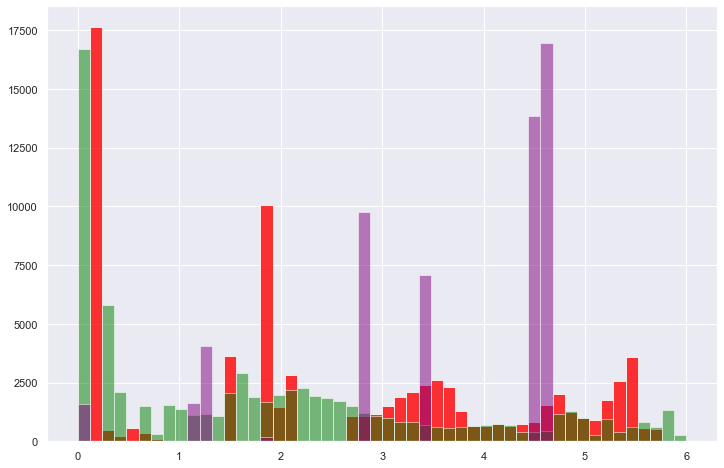

In [113]:

fig = np.log10(dftest_all['predictions']+1).hist(bins=50,  range=[0,6], alpha=0.8, figsize=(12,8), color='red')
fig = np.log10(dftest_all['timedelta']+1).hist(bins=50,  range=[0,6], alpha=0.5, color='green')
fig = np.log10(tdbl).hist(bins=50,  range=[0,6], alpha=0.5, color='purple')
fig.figure.savefig('histograms.png', dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


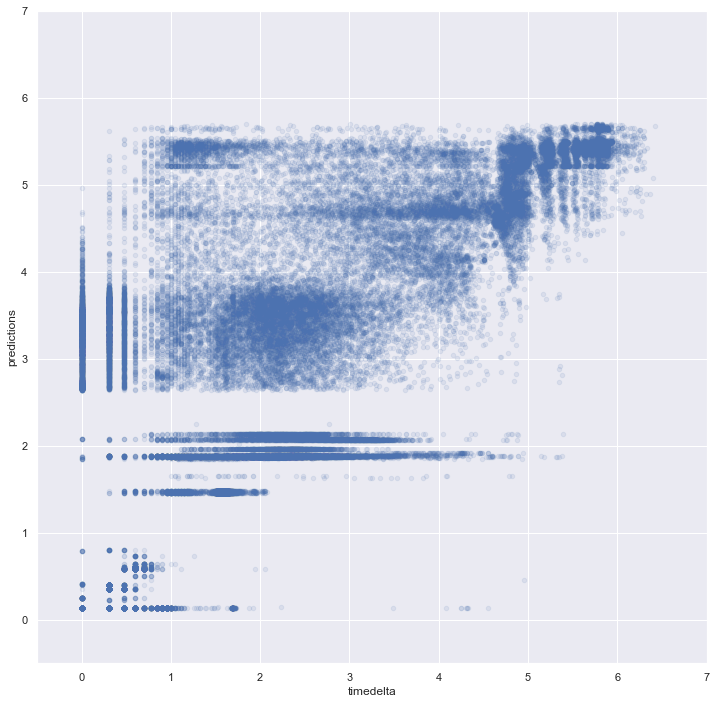

In [63]:
np.log10(dftest_all+1).plot.scatter(x='timedelta', y='predictions',alpha=0.1, figsize=(12,12), grid=True, ylim=(-.5,7), xlim=(-.5,7)).figure.savefig('logscatter.png', dpi=300)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='timedelta', ylabel='error'>

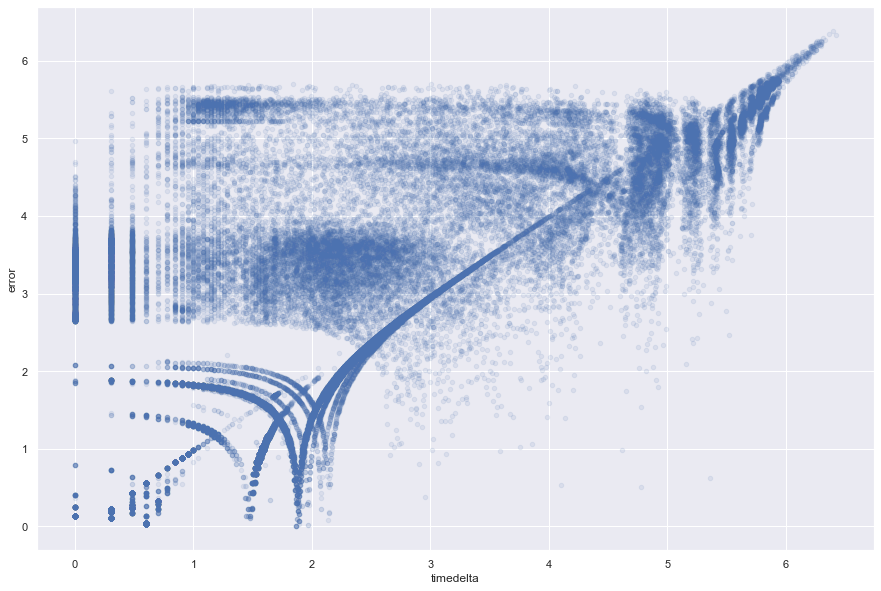

In [64]:
np.log10(dftest_all+1).plot.scatter(x='timedelta', y='error',alpha=0.1, figsize=(15,10), grid=True)

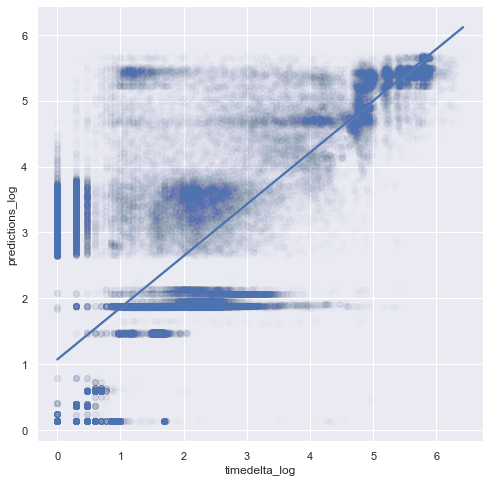

In [65]:
dftest_all['timedelta_log'] = np.log10(dftest_all['timedelta']+1)
dftest_all['predictions_log'] = np.log10(dftest_all['predictions']+1)
sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.regplot(x='timedelta_log', y='predictions_log', data=dftest_all, scatter_kws={'alpha':0.01}, fit_reg=True)


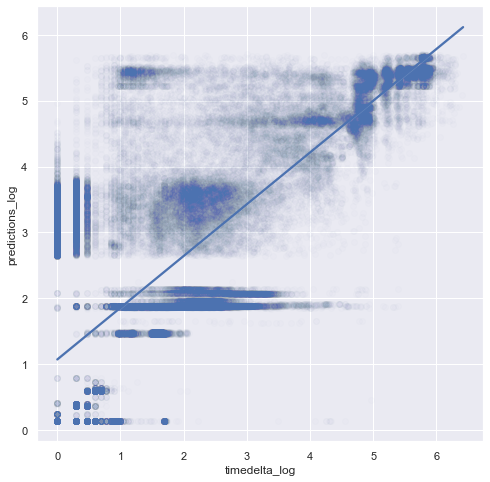

In [66]:
dftest_all['timedelta_log'] = np.log10(dftest_all['timedelta']+1)
dftest_all['predictions_log'] = np.log10(dftest_all['predictions']+1)
ax = sns.regplot(x='timedelta_log', y='predictions_log', data=dftest_all, scatter_kws={'alpha':0.01}, fit_reg=True)

In [67]:
logr2 = stats.pearsonr(x=dftest_all['timedelta_log'], y=dftest_all['predictions_log'])
r2 = stats.pearsonr(x=dftest_all['timedelta'], y=dftest_all['predictions'])
print('logr2 = ', logr2)
print('r2score = ', r2)

logr2 =  (0.7470005542873918, 0.0)
r2score =  (0.6369972665280123, 0.0)


In [68]:
end1 = time.time()
print(end1-start1)

429.0623803138733


# Neural Network for next event prediction